In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv


In [3]:
import pandas as pd
import os

# List of all relevant file paths
file_paths = [
    "/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

# Load all CSVs into a list of DataFrames
dataframes = []
for path in file_paths:
    print(f"📥 Loading: {os.path.basename(path)}")
    df = pd.read_csv(path, low_memory=False)
    dataframes.append(df)

# Optional: Combine them all into one DataFrame (you can filter before this)
all_data = pd.concat(dataframes, ignore_index=True)

# Quick look at structure
print("\n✅ Loaded combined dataset")
print("Shape:", all_data.shape)
print("Columns:", all_data.columns.tolist())
print("Unique labels:", all_data[' Label'].unique())

📥 Loading: Monday-WorkingHours.pcap_ISCX.csv
📥 Loading: Tuesday-WorkingHours.pcap_ISCX.csv
📥 Loading: Wednesday-workingHours.pcap_ISCX.csv
📥 Loading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
📥 Loading: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
📥 Loading: Friday-WorkingHours-Morning.pcap_ISCX.csv
📥 Loading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
📥 Loading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

✅ Loaded combined dataset
Shape: (2830743, 79)
Columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IA

In [4]:
import pandas as pd

# Step 1: Standardize column names (strip spaces)
all_data.columns = all_data.columns.str.strip()

# Step 2: Keep only relevant labels
filtered_df = all_data[all_data['Label'].isin(['BENIGN', 'DDoS'])].copy()

# Step 3: Select Zeek-compatible features
selected_ddos_features = [
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets',
    'Total Length of Fwd Packets',
    'Total Length of Bwd Packets',
    'Destination Port',
    'Label'
]

filtered_df = filtered_df[selected_ddos_features]

# Step 4: Report final shape
print(f"\n✅ Filtered dataset shape: {filtered_df.shape}")
print("Label distribution:")
print(filtered_df['Label'].value_counts())



✅ Filtered dataset shape: (2401124, 7)
Label distribution:
Label
BENIGN    2273097
DDoS       128027
Name: count, dtype: int64


In [5]:
filtered_df.dtypes

Flow Duration                   int64
Total Fwd Packets               int64
Total Backward Packets          int64
Total Length of Fwd Packets     int64
Total Length of Bwd Packets     int64
Destination Port                int64
Label                          object
dtype: object

In [7]:
filtered_df.isna().sum()

Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Destination Port               0
Label                          0
dtype: int64


📊 Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    681930
        DDoS       1.00      1.00      1.00     38408

    accuracy                           1.00    720338
   macro avg       1.00      1.00      1.00    720338
weighted avg       1.00      1.00      1.00    720338


🌟 Macro F1-Score: 0.9996


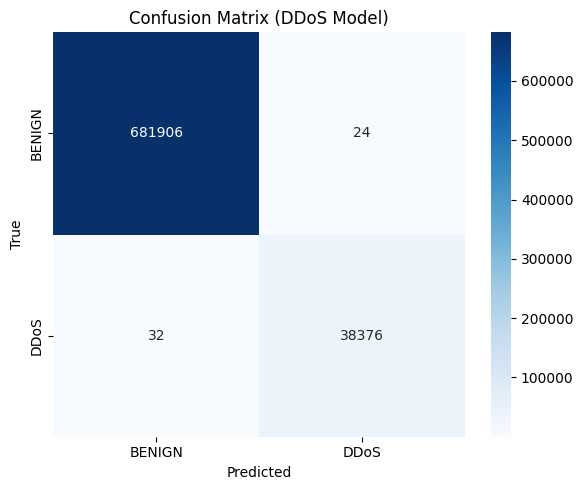

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Clean feature names if not already done
filtered_df.columns = filtered_df.columns.str.strip()

# Step 2: Encode labels (BENIGN=0, DDoS=1)
label_encoder = LabelEncoder()
filtered_df['Label_encoded'] = label_encoder.fit_transform(filtered_df['Label'])

# Step 3: Prepare data
X = filtered_df.drop(columns=['Label', 'Label_encoded'])
y = filtered_df['Label_encoded']

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Step 6: Train model
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Step 7: Evaluate
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\n🌟 Macro F1-Score: {macro_f1:.4f}")

# Step 8: Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (DDoS Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [9]:
import joblib

# Save trained model
joblib.dump(clf, 'ddos_zeek_model.pkl')

# Save label encoder
joblib.dump(label_encoder, 'ddos_zeek_label_encoder.pkl')

print("✅ Model and label encoder saved.")

# Rebuild final dataset used for training
final_ddos_dataset = X.copy()
final_ddos_dataset['Label'] = filtered_df['Label']

# Save dataset as CSV
final_ddos_dataset.to_csv('ddos_dataset_for_training.csv', index=False)

print("✅ Final dataset saved as 'ddos_dataset_for_training.csv'")


✅ Model and label encoder saved.
✅ Final dataset saved as 'ddos_dataset_for_training.csv'
